In [723]:

import tensorflow as tf
    
# tf.config.experimental.set_visible_devices([], 'GPU')
# tf.debugging.set_log_device_placement(True)
for gpu in tf.config.experimental.list_physical_devices('GPU'):
    print(gpu)
    tf.config.experimental.set_memory_growth(gpu, True)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [724]:
score_X.head()

,temperature,humidity,pressure,wind_speed,city_Albuquerque,city_Atlanta,city_Boston,city_Charlotte,city_Chicago,city_Dallas,...,day_of_week_cos,month_sin,month_cos,city_Haifa,city_Jerusalem,city_Nahariyya,city_New York,city_Portland,city_San Francisco,city_Tel Aviv District
0,292.03,49.0,1027.0,3.0,True,False,False,False,False,False,...,-0.222521,1.224647e-16,-1.0,0,0,0,0,0,0,0
1,292.07,56.0,1027.0,3.0,True,False,False,False,False,False,...,-0.222521,1.224647e-16,-1.0,0,0,0,0,0,0,0
2,295.62,49.0,1028.0,2.0,True,False,False,False,False,False,...,-0.222521,1.224647e-16,-1.0,0,0,0,0,0,0,0
3,296.63,44.0,1028.0,3.0,True,False,False,False,False,False,...,-0.222521,1.224647e-16,-1.0,0,0,0,0,0,0,0
4,299.15,36.0,1027.0,3.0,True,False,False,False,False,False,...,-0.222521,1.224647e-16,-1.0,0,0,0,0,0,0,0


In [725]:
653356 - (653356 % 24)


653352

In [726]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%config InlineBackend.figure_format = 'retina'
sns.set_context('talk')

In [727]:
%%capture
prefix = 'https://danylo-ucla.s3-us-west-2.amazonaws.com/app/storage/weather/jobs/transform_batch/20220925-014051_e32aa567fa482e970513332d1d24fd51'

train_X = pd.read_parquet(f'{prefix}/train_x.parquet')
train_y = pd.read_parquet(f'{prefix}/train_y.parquet')

validate_X = pd.read_parquet(f'{prefix}/validate_x.parquet')
validate_y = pd.read_parquet(f'{prefix}/validate_y.parquet')

test_X = pd.read_parquet(f'{prefix}/test_x.parquet')
test_y = pd.read_parquet(f'{prefix}/test_y.parquet')

score_X = pd.read_parquet(f'{prefix}/score_x.parquet')

condition_window = 24
prediction_window = 24
features_length = 11

In [728]:
train_X.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 826464 entries, ('Albuquerque/1108/0', Timestamp('2015-02-16 09:00:00')) to ('Vancouver/806/12', Timestamp('2014-07-03 04:00:00'))
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   temperature  826464 non-null  float64
 1   humidity     826464 non-null  float64
 2   pressure     826464 non-null  float64
 3   wind_speed   826464 non-null  float64
dtypes: float64(4)
memory usage: 31.9+ MB


In [729]:
train_X.index

MultiIndex([('Albuquerque/1108/0', '2015-02-16 09:00:00'),
            ('Albuquerque/1108/0', '2015-02-16 10:00:00'),
            ('Albuquerque/1108/0', '2015-02-16 11:00:00'),
            ('Albuquerque/1108/0', '2015-02-16 12:00:00'),
            ('Albuquerque/1108/0', '2015-02-16 13:00:00'),
            ('Albuquerque/1108/0', '2015-02-16 14:00:00'),
            ('Albuquerque/1108/0', '2015-02-16 15:00:00'),
            ('Albuquerque/1108/0', '2015-02-16 16:00:00'),
            ('Albuquerque/1108/0', '2015-02-16 17:00:00'),
            ('Albuquerque/1108/0', '2015-02-16 18:00:00'),
            ...
            (  'Vancouver/806/12', '2014-07-02 19:00:00'),
            (  'Vancouver/806/12', '2014-07-02 20:00:00'),
            (  'Vancouver/806/12', '2014-07-02 21:00:00'),
            (  'Vancouver/806/12', '2014-07-02 22:00:00'),
            (  'Vancouver/806/12', '2014-07-02 23:00:00'),
            (  'Vancouver/806/12', '2014-07-03 00:00:00'),
            (  'Vancouver/806/12', '2014

In [730]:
validate_X.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 54912 entries, ('Albuquerque/2102/0', Timestamp('2017-02-28 20:00:00')) to ('Vancouver/2479/10', Timestamp('2017-03-22 15:00:00'))
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   temperature  54912 non-null  float64
 1   humidity     54912 non-null  float64
 2   pressure     54912 non-null  float64
 3   wind_speed   54912 non-null  float64
dtypes: float64(4)
memory usage: 2.0+ MB


In [731]:
test_X.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 52248 entries, ('Albuquerque/2155/0', Timestamp('2017-04-14 08:00:00')) to ('Vancouver/2511/2', Timestamp('2017-04-19 11:00:00'))
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   temperature  52248 non-null  float64
 1   humidity     52248 non-null  float64
 2   pressure     52248 non-null  float64
 3   wind_speed   52248 non-null  float64
dtypes: float64(4)
memory usage: 2.0+ MB


In [732]:
train_X.groupby('sample').size().head()

sample
Albuquerque/1108/0    24
Albuquerque/1108/1    24
Albuquerque/1108/2    24
Albuquerque/1112/0    24
Albuquerque/1112/1    24
dtype: int64

In [733]:
train_X.loc['Albuquerque/1112/1'].head(24)

,temperature,humidity,pressure,wind_speed
time,,,,
2015-02-20 18:00:00,282.116500,46.0,1023.0,3.0
2015-02-20 19:00:00,287.061667,40.0,1021.0,4.0
2015-02-20 20:00:00,288.236333,38.0,1019.0,4.0
2015-02-20 21:00:00,286.928000,35.0,1020.0,4.0
2015-02-20 22:00:00,288.930333,34.0,1017.0,5.0
2015-02-20 23:00:00,288.449667,31.0,1017.0,5.0
2015-02-21 00:00:00,286.976000,30.0,1019.0,4.0
2015-02-21 01:00:00,286.826333,27.0,1018.0,5.0
2015-02-21 02:00:00,285.683667,26.0,1019.0,5.0


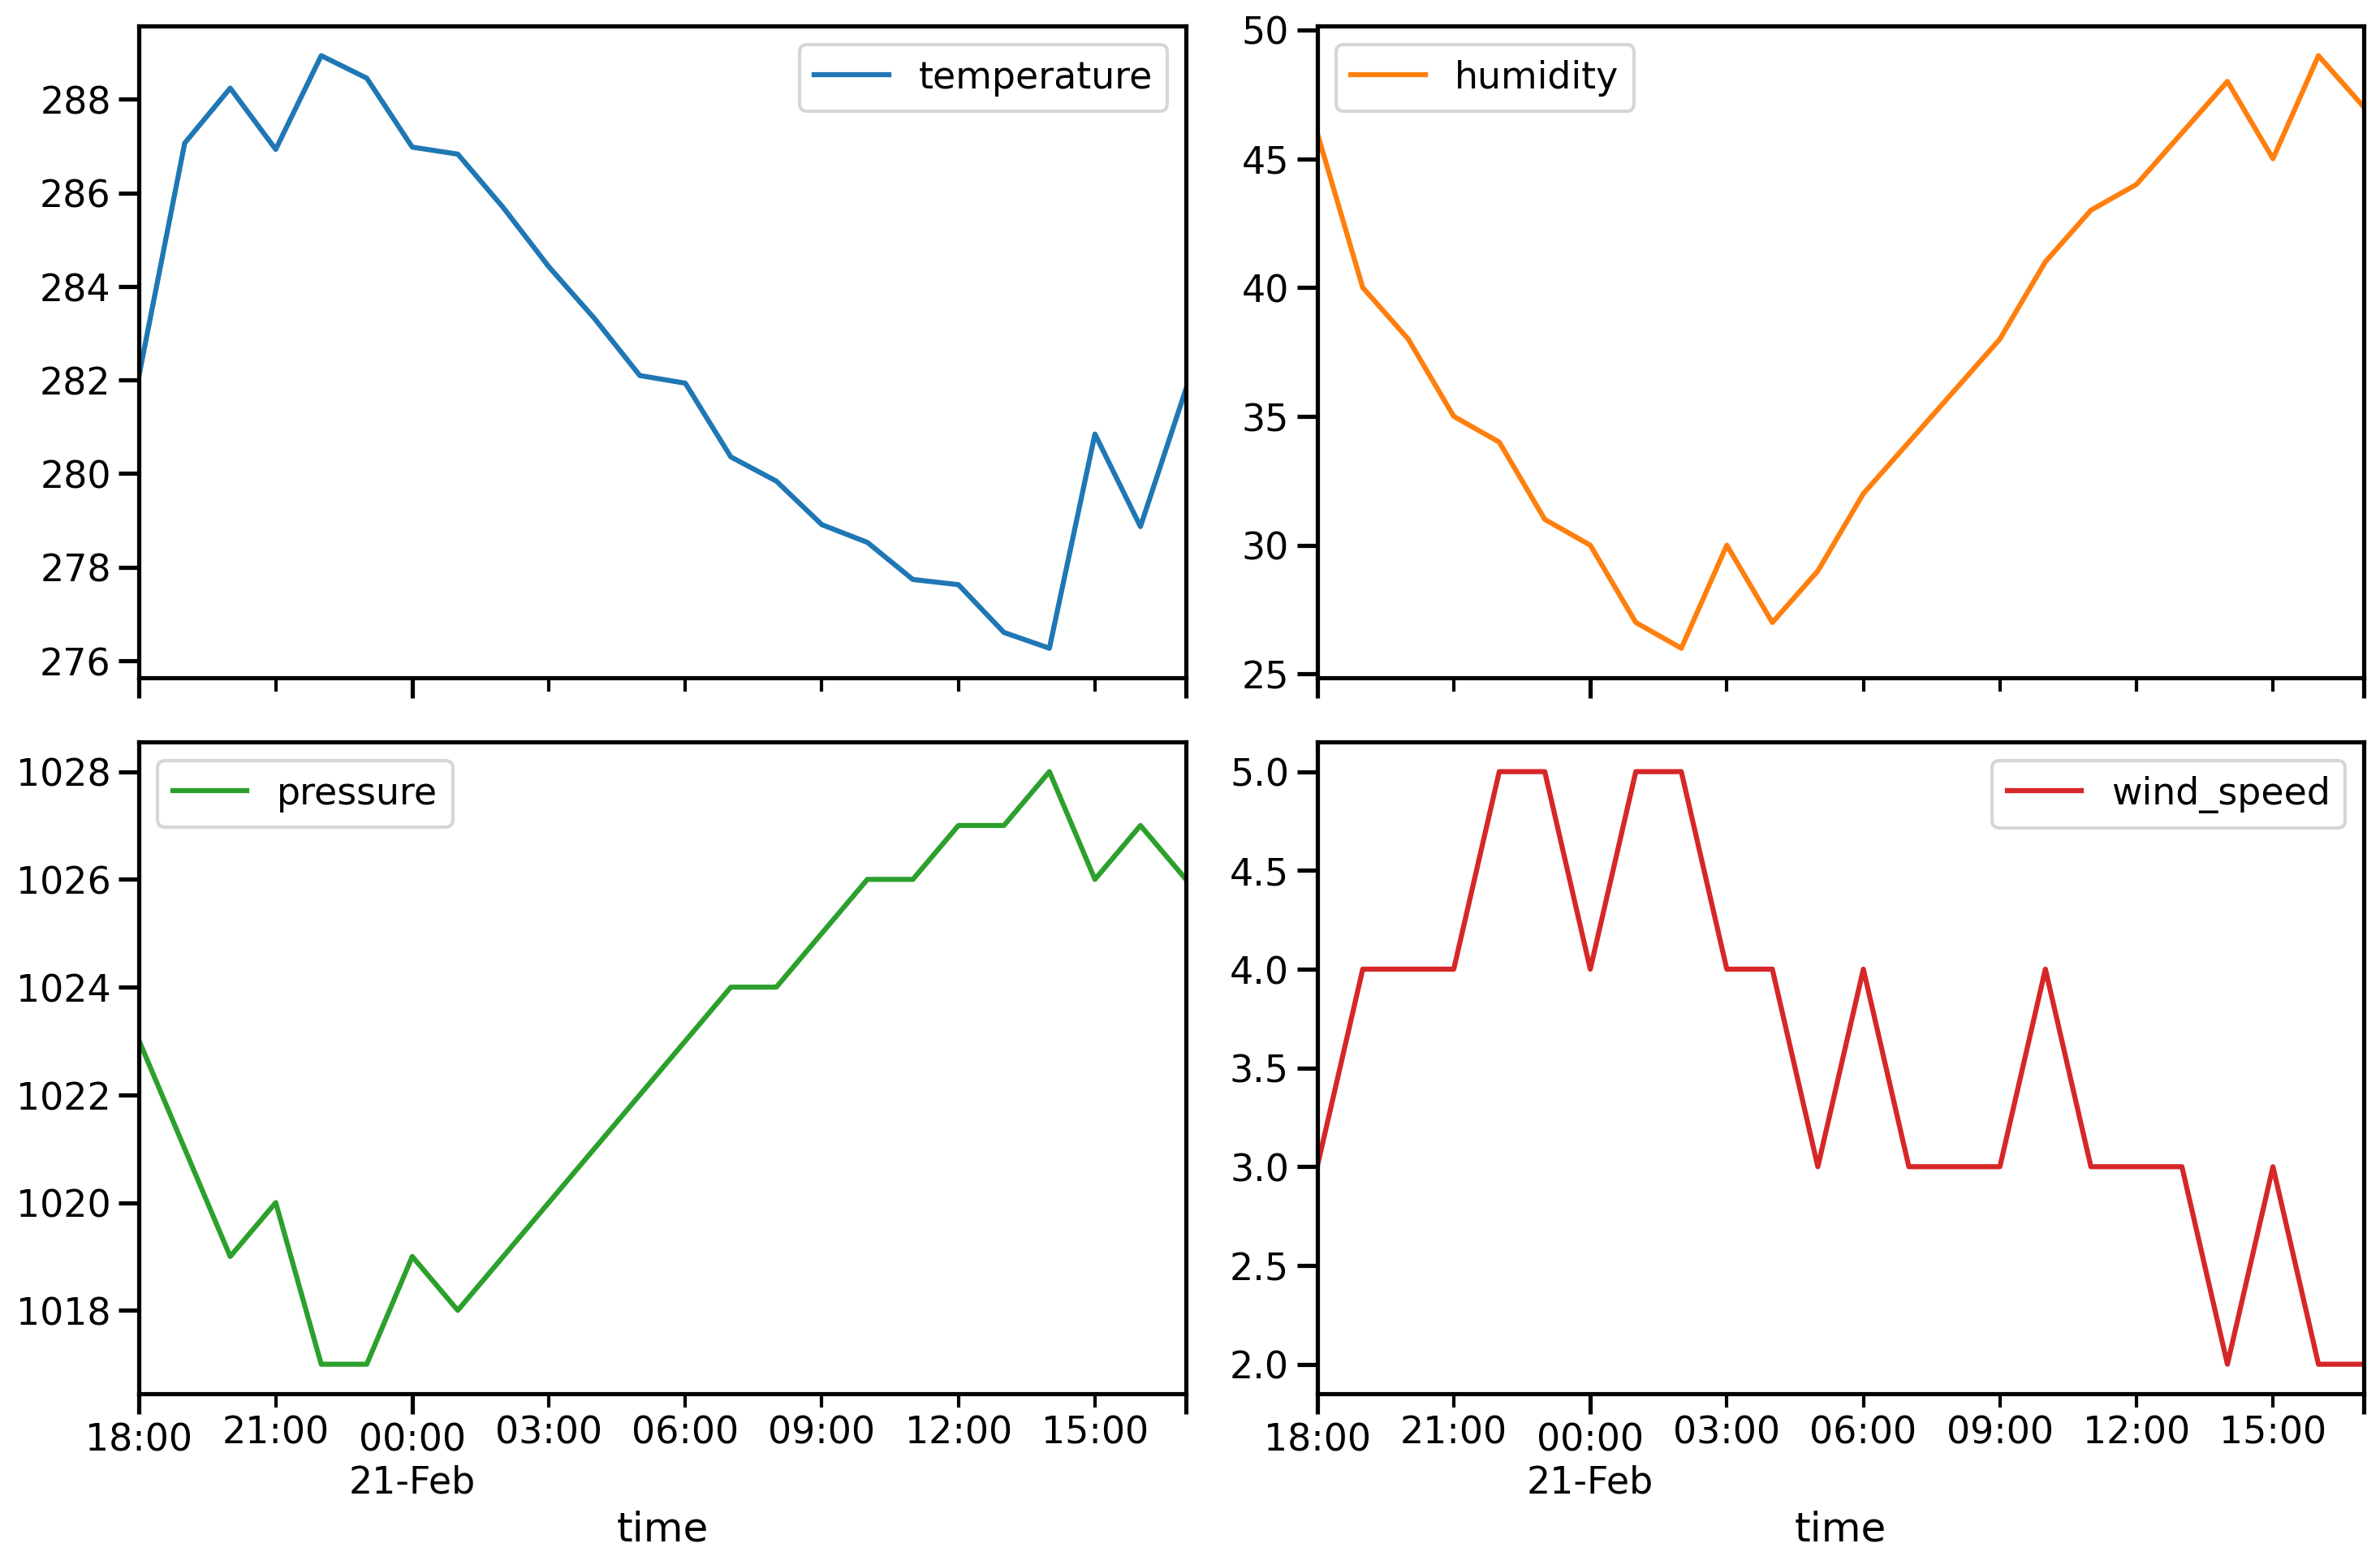

In [734]:
train_X.loc['Albuquerque/1112/1'].plot(subplots=True, layout=(2, 2), figsize=[15, 10])
plt.tight_layout()

In [735]:
train_y.loc['Albuquerque/1112/1'].head(24)

,temperature,humidity,pressure,wind_speed
time,,,,
2015-02-21 18:00:00,282.091500,44.0,1024.0,3.0
2015-02-21 19:00:00,285.914000,43.0,1023.0,3.0
2015-02-21 20:00:00,287.083000,40.0,1021.0,4.0
2015-02-21 21:00:00,286.046500,37.0,1022.0,5.0
2015-02-21 22:00:00,287.950667,34.0,1019.0,6.0
2015-02-21 23:00:00,287.649333,31.0,1019.0,6.0
2015-02-22 00:00:00,285.892000,30.0,1021.0,4.0
2015-02-22 01:00:00,286.076000,26.0,1020.0,5.0
2015-02-22 02:00:00,284.804000,25.0,1021.0,4.0


In [736]:
train_size = 653352
validate_size = 140136
test_size = 140136


In [737]:
combined_X = pd.concat([train_X, validate_X, test_X])
combined_y = pd.concat([train_y, validate_y, test_y])

In [738]:
train_X = combined_X.iloc[:train_size]
validate_X = combined_X.iloc[train_size:train_size + validate_size]
test_X = combined_X.iloc[train_size + validate_size:]


In [739]:
train_y = combined_y.iloc[:train_size]
validate_y = combined_y.iloc[train_size:train_size + validate_size]
test_y = combined_y.iloc[train_size + validate_size:]


In [740]:

combined_X = combined_X.reset_index()

combined_X['hour'] = combined_X['time'].dt.hour
combined_X['day_of_week'] = combined_X['time'].dt.dayofweek
combined_X['month'] = combined_X['time'].dt.month

combined_X['city'] = combined_X['sample'].str.split('/').str[0]






In [741]:

score_X = score_X.reset_index()


score_X['hour'] = score_X['time'].dt.hour
score_X['day_of_week'] = score_X['time'].dt.dayofweek
score_X['month'] = score_X['time'].dt.month


score_X['city'] = score_X['sample'].str.split('/').str[0]






In [742]:

train_X = combined_X.iloc[:train_size]
validate_X = combined_X.iloc[train_size:train_size + validate_size]
test_X = combined_X.iloc[train_size + validate_size:]


In [743]:
print(f"Training set size: {len(train_X)}")
print(f"Validation set size: {len(validate_X)}")
print(f"Test set size: {len(test_X)}")


Training set size: 653352
Validation set size: 140136
Test set size: 140136


In [744]:
print(f"Training set size: {len(train_y)}")
print(f"Validation set size: {len(validate_y)}")
print(f"Test set size: {len(test_y)}")


Training set size: 653352
Validation set size: 140136
Test set size: 140136


In [745]:
train_X.drop(['sample', 'time'], axis=1,  inplace=True)
validate_X.drop(['sample', 'time'], axis=1,  inplace=True)
test_X.drop(['sample', 'time'], axis=1,  inplace=True)

/tmp/ipykernel_28/715780050.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_X.drop(['sample', 'time'], axis=1,  inplace=True)
/tmp/ipykernel_28/715780050.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validate_X.drop(['sample', 'time'], axis=1,  inplace=True)
/tmp/ipykernel_28/715780050.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_X.drop(['sample', 'time'], axis=1,  inplace=True)


In [746]:
score_X.drop(['sample', 'time'], axis=1,  inplace=True)

In [747]:
train_y.drop(['pressure', 'humidity', 'wind_speed'], axis=1, inplace=True)

/tmp/ipykernel_28/4126878279.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_y.drop(['pressure', 'humidity', 'wind_speed'], axis=1, inplace=True)


In [748]:
validate_y.drop(['pressure', 'humidity', 'wind_speed'], axis=1, inplace=True)

/tmp/ipykernel_28/1438616087.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validate_y.drop(['pressure', 'humidity', 'wind_speed'], axis=1, inplace=True)


In [749]:

train_X['hour_sin'] = np.sin(2 * np.pi * train_X['hour'] / 24)
train_X['hour_cos'] = np.cos(2 * np.pi * train_X['hour'] / 24)


train_X['day_of_week_sin'] = np.sin(2 * np.pi * train_X['day_of_week'] / 7)
train_X['day_of_week_cos'] = np.cos(2 * np.pi * train_X['day_of_week'] / 7)


train_X['month_sin'] = np.sin(2 * np.pi * (train_X['month'] - 1) / 12)
train_X['month_cos'] = np.cos(2 * np.pi * (train_X['month'] - 1) / 12)

/tmp/ipykernel_28/3978312769.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_X['hour_sin'] = np.sin(2 * np.pi * train_X['hour'] / 24)
/tmp/ipykernel_28/3978312769.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_X['hour_cos'] = np.cos(2 * np.pi * train_X['hour'] / 24)
/tmp/ipykernel_28/3978312769.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: ht

In [750]:

validate_X['hour_sin'] = np.sin(2 * np.pi * validate_X['hour'] / 24)
validate_X['hour_cos'] = np.cos(2 * np.pi * validate_X['hour'] / 24)

validate_X['day_of_week_sin'] = np.sin(2 * np.pi * validate_X['day_of_week'] / 7)
validate_X['day_of_week_cos'] = np.cos(2 * np.pi * validate_X['day_of_week'] / 7)


validate_X['month_sin'] = np.sin(2 * np.pi * (validate_X['month'] - 1) / 12)
validate_X['month_cos'] = np.cos(2 * np.pi * (validate_X['month'] - 1) / 12)

/tmp/ipykernel_28/3096919550.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validate_X['hour_sin'] = np.sin(2 * np.pi * validate_X['hour'] / 24)
/tmp/ipykernel_28/3096919550.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validate_X['hour_cos'] = np.cos(2 * np.pi * validate_X['hour'] / 24)
/tmp/ipykernel_28/3096919550.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

In [751]:

test_X['hour_sin'] = np.sin(2 * np.pi * test_X['hour'] / 24)
test_X['hour_cos'] = np.cos(2 * np.pi * test_X['hour'] / 24)


test_X['day_of_week_sin'] = np.sin(2 * np.pi * test_X['day_of_week'] / 7)
test_X['day_of_week_cos'] = np.cos(2 * np.pi * test_X['day_of_week'] / 7)


test_X['month_sin'] = np.sin(2 * np.pi * (test_X['month'] - 1) / 12)
test_X['month_cos'] = np.cos(2 * np.pi * (test_X['month'] - 1) / 12)

/tmp/ipykernel_28/896385767.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_X['hour_sin'] = np.sin(2 * np.pi * test_X['hour'] / 24)
/tmp/ipykernel_28/896385767.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_X['hour_cos'] = np.cos(2 * np.pi * test_X['hour'] / 24)
/tmp/ipykernel_28/896385767.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

In [752]:

score_X['hour_sin'] = np.sin(2 * np.pi * score_X['hour'] / 24)
score_X['hour_cos'] = np.cos(2 * np.pi * score_X['hour'] / 24)


score_X['day_of_week_sin'] = np.sin(2 * np.pi * score_X['day_of_week'] / 7)
score_X['day_of_week_cos'] = np.cos(2 * np.pi * score_X['day_of_week'] / 7)


score_X['month_sin'] = np.sin(2 * np.pi * (score_X['month'] - 1) / 12)
score_X['month_cos'] = np.cos(2 * np.pi * (score_X['month'] - 1) / 12)

In [753]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_X['city_encoded'] = label_encoder.fit_transform(train_X['city'])

/tmp/ipykernel_28/2789090019.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_X['city_encoded'] = label_encoder.fit_transform(train_X['city'])


In [754]:
validate_X['city_encoded'] = label_encoder.fit_transform(validate_X['city'])

/tmp/ipykernel_28/3676679770.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validate_X['city_encoded'] = label_encoder.fit_transform(validate_X['city'])


In [755]:
test_X['city_encoded'] = label_encoder.fit_transform(test_X['city'])

/tmp/ipykernel_28/1334947919.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_X['city_encoded'] = label_encoder.fit_transform(test_X['city'])


In [756]:
score_X['city_encoded'] = label_encoder.fit_transform(score_X['city'])

In [757]:
train_X.drop(['city', 'month', 'hour', 'day_of_week'], axis=1, inplace=True)

/tmp/ipykernel_28/3804058985.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_X.drop(['city', 'month', 'hour', 'day_of_week'], axis=1, inplace=True)


In [758]:
validate_X.drop(['city', 'month', 'hour', 'day_of_week'], axis=1, inplace=True)

/tmp/ipykernel_28/3330754066.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validate_X.drop(['city', 'month', 'hour', 'day_of_week'], axis=1, inplace=True)


In [759]:
test_X.drop(['city', 'month', 'hour', 'day_of_week'], axis=1, inplace=True)

/tmp/ipykernel_28/555932412.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_X.drop(['city', 'month', 'hour', 'day_of_week'], axis=1, inplace=True)


In [760]:
score_X.drop(['city', 'month', 'hour', 'day_of_week'], axis=1, inplace=True)

In [761]:
train_X.head()

,temperature,humidity,pressure,wind_speed,hour_sin,hour_cos,day_of_week_sin,day_of_week_cos,month_sin,month_cos,city_encoded
0,276.323000,47.0,1031.0,3.0,7.071068e-01,-0.707107,0.0,1.0,0.5,0.866025,0
1,275.097667,45.0,1032.0,3.0,5.000000e-01,-0.866025,0.0,1.0,0.5,0.866025,0
2,273.931333,48.0,1032.0,2.0,2.588190e-01,-0.965926,0.0,1.0,0.5,0.866025,0
3,274.380000,46.0,1033.0,2.0,1.224647e-16,-1.000000,0.0,1.0,0.5,0.866025,0
4,272.675333,51.0,1033.0,1.0,-2.588190e-01,-0.965926,0.0,1.0,0.5,0.866025,0


In [762]:
validate_X.head()

,temperature,humidity,pressure,wind_speed,hour_sin,hour_cos,day_of_week_sin,day_of_week_cos,month_sin,month_cos,city_encoded
653352,276.650000,59.0,1027.0,5.0,-0.707107,0.707107,0.433884,-0.900969,0.866025,0.5,0
653353,279.030667,67.0,1036.0,2.0,-0.500000,0.866025,0.433884,-0.900969,0.866025,0.5,0
653354,276.855333,61.0,1031.0,3.0,-0.258819,0.965926,0.433884,-0.900969,0.866025,0.5,0
653355,274.680000,55.0,1027.0,4.0,0.000000,1.000000,-0.433884,-0.900969,0.866025,0.5,0
653356,273.495000,61.0,1027.0,3.0,0.258819,0.965926,-0.433884,-0.900969,0.866025,0.5,0


In [763]:
test_X.head()

,temperature,humidity,pressure,wind_speed,hour_sin,hour_cos,day_of_week_sin,day_of_week_cos,month_sin,month_cos,city_encoded
793488,283.35,64.0,1019.0,3.0,0.258819,0.965926,-0.781831,0.62349,0.866025,-0.5,30
793489,281.71,71.0,1020.0,2.0,0.500000,0.866025,-0.781831,0.62349,0.866025,-0.5,30
793490,280.66,67.0,1021.0,1.0,0.707107,0.707107,-0.781831,0.62349,0.866025,-0.5,30
793491,279.64,90.0,1021.0,4.0,0.866025,0.500000,-0.781831,0.62349,0.866025,-0.5,30
793492,278.73,81.0,1021.0,2.0,0.965926,0.258819,-0.781831,0.62349,0.866025,-0.5,30


In [764]:
score_X.head()

,temperature,humidity,pressure,wind_speed,hour_sin,hour_cos,day_of_week_sin,day_of_week_cos,month_sin,month_cos,city_encoded
0,292.03,49.0,1027.0,3.0,-0.258819,-0.965926,-0.974928,-0.222521,1.224647e-16,-1.0,0
1,292.07,56.0,1027.0,3.0,-0.500000,-0.866025,-0.974928,-0.222521,1.224647e-16,-1.0,0
2,295.62,49.0,1028.0,2.0,-0.707107,-0.707107,-0.974928,-0.222521,1.224647e-16,-1.0,0
3,296.63,44.0,1028.0,3.0,-0.866025,-0.500000,-0.974928,-0.222521,1.224647e-16,-1.0,0
4,299.15,36.0,1027.0,3.0,-0.965926,-0.258819,-0.974928,-0.222521,1.224647e-16,-1.0,0


In [765]:
train_y.shape

(653352, 1)

In [766]:
validate_y.shape

(140136, 1)

In [767]:
train_columns = train_X.columns

# Align columns in validate_X
for col in train_columns:
    if col not in score_X.columns:
        score_X[col] = 0

In [768]:
score_X.shape

(57576, 11)

In [769]:
score_X.reindex(columns=train_X.columns, fill_value=0)

,temperature,humidity,pressure,wind_speed,hour_sin,hour_cos,day_of_week_sin,day_of_week_cos,month_sin,month_cos,city_encoded
0,292.03,49.0,1027.0,3.0,-0.258819,-9.659258e-01,-0.974928,-0.222521,1.224647e-16,-1.0,0
1,292.07,56.0,1027.0,3.0,-0.500000,-8.660254e-01,-0.974928,-0.222521,1.224647e-16,-1.0,0
2,295.62,49.0,1028.0,2.0,-0.707107,-7.071068e-01,-0.974928,-0.222521,1.224647e-16,-1.0,0
3,296.63,44.0,1028.0,3.0,-0.866025,-5.000000e-01,-0.974928,-0.222521,1.224647e-16,-1.0,0
4,299.15,36.0,1027.0,3.0,-0.965926,-2.588190e-01,-0.974928,-0.222521,1.224647e-16,-1.0,0
...,...,...,...,...,...,...,...,...,...,...,...
57571,292.10,50.0,1024.0,2.0,-0.866025,-5.000000e-01,-0.433884,-0.900969,1.224647e-16,-1.0,27
57572,291.82,67.0,1021.0,5.0,-0.965926,-2.588190e-01,-0.433884,-0.900969,1.224647e-16,-1.0,27
57573,292.65,63.0,1021.0,5.0,-1.000000,-1.836970e-16,-0.433884,-0.900969,1.224647e-16,-1.0,27
57574,291.81,59.0,1022.0,8.0,-0.965926,2.588190e-01,-0.433884,-0.900969,1.224647e-16,-1.0,27


In [771]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(train_X)

scaled_X = {
    'train': scaler.transform(train_X),
    'validate': scaler.transform(validate_X),
    'test': scaler.transform(test_X),
    'score': scaler.transform(score_X),
}

In [772]:
features_length = 11

In [773]:


def expected_X_shape(actual_X_shape):
    return (int(actual_X_shape[0]/condition_window), condition_window, features_length)

def expected_y_shape(actual_y_shape):
    return (int(actual_y_shape[0]/prediction_window), prediction_window)


pd.DataFrame({
    'actual shape': [
        train_X.shape, 
        train_y.shape,
    ],
    'expected shape': [
        expected_X_shape(train_X.shape), 
        expected_y_shape(train_y.shape), 
    ],
}, index=['train_X', 'train_y'])

,actual shape,expected shape
train_X,"(653352, 11)","(27223, 24, 11)"
train_y,"(653352, 1)","(27223, 24)"


In [774]:


def frame_to_ndarray(frame_X, frame_y):
    X_nd = frame_X.reshape(-1, condition_window, features_length).astype('float32')
    y_nd = frame_y['temperature'].values.reshape(-1, prediction_window).astype('float32')
    return X_nd, y_nd
def frame_to_ndarray_score(frame_X):
    X_nd = frame_X.reshape(-1, condition_window, features_length).astype('float32')
    return X_nd

train_X_nd, train_y_nd = frame_to_ndarray(scaled_X['train'], train_y)
validate_X_nd, validate_y_nd = frame_to_ndarray(scaled_X['validate'], validate_y)
test_X_nd, test_y_nd = frame_to_ndarray(scaled_X['test'], test_y)
score_X_nd = frame_to_ndarray_score(scaled_X['score'])


In [775]:


pd.DataFrame({
    'actual shape': [
        train_X_nd.shape, 
        train_y_nd.shape,
        validate_X_nd.shape,
        validate_y_nd.shape,
    ],
    'expected shape': [
        expected_X_shape(train_X.shape), 
        expected_y_shape(train_y.shape), 
        expected_X_shape(validate_X.shape), 
        expected_y_shape(validate_y.shape), 
    ]},
    index=['train_X', 'train_y', 'validate_X', 'validate_y']
)

,actual shape,expected shape
train_X,"(27223, 24, 11)","(27223, 24, 11)"
train_y,"(27223, 24)","(27223, 24)"
validate_X,"(5839, 24, 11)","(5839, 24, 11)"
validate_y,"(5839, 24)","(5839, 24)"


In [783]:
dropout_rate = 0.3  
learning_rate = 1e-3 
l1_reg = 1e-1
clip_value = 1.0 
features_length = 11

In [784]:
import tensorflow as tf
from tensorflow.keras.layers import LSTM, BatchNormalization, Dense, Dropout, GlobalAveragePooling1D
from tensorflow.keras.initializers import GlorotUniform


model = tf.keras.Sequential([
    # First LSTM layer
    LSTM(
        units=40,
        return_sequences=True,  # Keep the sequence for the next LSTM
        input_shape=(condition_window, features_length),
        kernel_regularizer=tf.keras.regularizers.l1(l1_reg),
        kernel_initializer=GlorotUniform(seed=42),
        recurrent_initializer=GlorotUniform(seed=43),
    ),
    Dropout(dropout_rate),  # Dropout layer after the first LSTM
    BatchNormalization(),
    LSTM(
        units=40,
        return_sequences=True,  # Only output the last time step
        kernel_initializer=GlorotUniform(seed=46),
        kernel_regularizer=tf.keras.regularizers.l1(l1_reg),
        recurrent_initializer=GlorotUniform(seed=47),
    ),
    Dropout(dropout_rate),  
    BatchNormalization(), 
        LSTM(
        units=40,
        return_sequences=False,  # Only output the last time step
        kernel_initializer=GlorotUniform(seed=46),
        kernel_regularizer=tf.keras.regularizers.l1(l1_reg),
        recurrent_initializer=GlorotUniform(seed=47),
    ),
    # Dropout(dropout_rate),  # Dropout layer after the second LSTM
    BatchNormalization(),
    # Dropout(dropout_rate),
    # Final Dense layer for 24-hour prediction
    Dense(
        units=24,  # Predict 24 values (for each hour of the day)
        kernel_initializer=GlorotUniform(seed=54),
        activation='linear'
    )
])


model.compile(optimizer='adam', loss='mse')


model.summary()


/app/conda/envs/collegium/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_43"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_120 (LSTM)                 │ (None, 24, 40)         │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_86 (Dropout)            │ (None, 24, 40)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_136         │ (None, 24, 40)         │           160 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_121 (LSTM)                 │ (None, 24, 40)         │        12,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_87 (Dropout)            │ (None, 24, 40)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_137         │ (None, 24, 40)         │           160 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_122 (LSTM)                 │ (None, 40)             │        12,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_138         │ (None, 40)             │           160 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 24)             │           984 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35,704 (139.47 KB)

 Trainable params: 35,464 (138.53 KB)

 Non-trainable params: 240 (960.00 B)

In [785]:
from utils import r2_score, mean_error
from tensorflow.keras.optimizers import Adam


model.compile(
    optimizer=Adam(learning_rate=0.008),
    loss='mean_squared_error',
    metrics=[
        'mean_absolute_error',
        mean_error,
        r2_score,
    ]
)

In [786]:
%%time

from tensorflow.keras.callbacks import TerminateOnNaN, ReduceLROnPlateau, EarlyStopping


history = model.fit(
    train_X_nd,
    train_y_nd,
    validation_data=(validate_X_nd, validate_y_nd),
    epochs=30,
    batch_size=100,
    callbacks=[
        TerminateOnNaN(),
        ReduceLROnPlateau(
            monitor='val_loss',
            min_delta=0.1,
            patience=5,
            factor=0.1,
            cooldown=2,
            verbose=1
        ),
        EarlyStopping(
            monitor='val_loss',
            min_delta=0.1,
            patience=10
        )
    ]
)

Epoch 1/30
273/273 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 65472.7969 - mean_absolute_error: 249.0944 - mean_error: -249.0911 - r2_score: -473.2616 - val_loss: 555.6659 - val_mean_absolute_error: 21.8804 - val_mean_error: -21.8390 - val_r2_score: -29.2604 - learning_rate: 0.0080
Epoch 2/30
273/273 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 138.3114 - mean_absolute_error: 8.8210 - mean_error: -7.2808 - r2_score: 0.0725 - val_loss: 30.6880 - val_mean_absolute_error: 3.8426 - val_mean_error: -0.4916 - val_r2_score: -0.1664 - learning_rate: 0.0080
Epoch 3/30
273/273 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 37.2784 - mean_absolute_error: 3.9423 - mean_error: 0.0304 - r2_score: 0.8162 - val_loss: 32.0169 - val_mean_absolute_error: 4.1772 - val_mean_error: -1.2437 - val_r2_score: -0.2923 - learning_rate: 0.0080
Epoch 4/30
273/273 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 22.8685 - mean_absolute_error: 3.3222 - mean_error: -0.0842 - r2_score: 0.8685 - val_loss: 16.1135 - val_mean_absolute_error

In [787]:


nd_array_by_segment = {
    'train': (train_X_nd, train_y_nd),
    'validate': (validate_X_nd, validate_y_nd),
    'test': (test_X_nd, test_y_nd)
}

metrics_by_segment = {
    segment: model.evaluate(
        X_nd, 
        y_nd, 
        verbose=0, 
        batch_size=X_nd.shape[0]
    )
    for segment, (X_nd, y_nd) in nd_array_by_segment.items()
}

rnn_metrics = pd.concat([
    pd.DataFrame(
        data=[metrics], 
        columns=['MSE', 'MAE', 'ME', 'R2'], 
        index=[segment]
    )
    for segment, metrics in metrics_by_segment.items()
])

rnn_metrics = pd.DataFrame([rnn_metrics.unstack()], index=['rnn'])\
    .swaplevel(axis=1, i=0, j=1)\
    .reindex(nd_array_by_segment.keys(), axis=1, level=0)\
    .round(2)

rnn_metrics

train                  validate                     test                 
       MSE  MAE    ME    R2      MSE   MAE    ME    R2    MSE   MAE   ME    R2
rnn  10.46  2.3 -0.04  0.93    10.78  2.26 -0.09  0.93  15.57  2.88 -0.1  0.87

In [788]:
from utils import SegmentDataset, baseline_metrics

segment_names = ['train', 'validate']
panel_dataset = SegmentDataset.from_pq_workdir(prefix, segment_names, ['x', 'y'])
baseline_metrics = baseline_metrics(panel_dataset)

/home/sagemaker-user/collegium/m03_rnn/utils.py:263: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  return reg.stack("time")
/home/sagemaker-user/collegium/m03_rnn/utils.py:263: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  return reg.stack("time")


In [789]:
pd.concat([
    baseline_metrics,
    rnn_metrics
], axis=0).loc[:, [('train', 'MSE'), ('train', 'R2'), ('validate', 'MSE'), ('validate', 'R2')]].round(2)

train       validate      
              MSE    R2      MSE    R2
mean        26.77  0.80    37.23  0.58
constant    21.82  0.84    40.25  0.54
regression  30.53  0.78    29.94  0.66
rnn         10.46  0.93    10.78  0.93

In [793]:

score_y_hat = model.predict(score_X_nd).ravel()
score_y_hat = pd.DataFrame(score_y_hat)

score_y_hat = pd.DataFrame(score_y_hat, columns=['Temperature'])

print(score_y_hat.columns, score_y_hat.shape)

75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Index(['Temperature'], dtype='object') (57576, 1)


In [798]:


import os
model_dir = 'weathernet_model'
os.makedirs(model_dir, exist_ok=True)

# Save model definition:
import json
with open(f'{model_dir}/keras_model.json', 'w') as f:
    model_json = json.dumps(json.loads(model.to_json()), indent=True)
    f.write(model_json)

# Save the learned parameters.
model.save_weights(f"{model_dir}/model.weights.h5")

# Finally, let's save the forecast.
score_y_hat.to_parquet(f'{model_dir}/score_y_hat.parquet')